# Multi-Agent Reinforcement Learning: Cournot Competition

This notebook demonstrates training neural network policies for agents in a Cournot oligopoly market.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from environment import CournotEnvironment
from policy import (
    PolicyNetwork_asymmetrical,
    PolicyNetwork_Nash
)
from trainer import CournotTrainer
from utils import (
    plot_training_convergence,
    plot_policy_response,
    plot_exploration_schedule,
    plot_action_distribution,
    plot_profit_analysis,
    compare_agents,
    print_evaluation_summary
)

# Matplotlib settings
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

## 1. Cournot Reinforcement Learning with Perfect Information

As a baseline and proof that our model works, we first train an agent on a Cournot competition with perfect information to show that our Reinforcement Learning model works (meaning it reach Nash Equilibrium when all assumptions are met).

In [3]:
# Create environment (SAME as above)
env_config = {
    "a_min": 80.0,
    "a_max": 120.0,
    "b_min": 0.8,
    "b_max": 1.2,
    "cost_min": 5.0,
    "cost_max": 50.0,
    "q_max": 100.0,
    "seed": 42
}
env = CournotEnvironment(env_config)

# Create policies - learning agent + opponent (4D input - KEY DIFFERENCE!)
learning_agent = PolicyNetwork_Nash(input_dim=4, hidden_dim=64)
opponent_agent = PolicyNetwork_Nash(input_dim=4, hidden_dim=64)
policies = [learning_agent, opponent_agent]

# Training configuration (SAME as above)
config = {
    'episodes': 100000,
    'lr_init': 0.003,
    'lr_final': 0.0001,
    'warmup_steps': 10000,
    'sigma_init': 12.0,
    'sigma_final': 3.0,
    'sigma_decay': 0.99996,
    'print_interval': 10000,
    
    # Self-play settings
    'opponent_update_interval': 1000,
    'learning_agent_id': 0
}

# Create trainer (SAME as above)
trainer = CournotTrainer(n_players=2, env=env, policies=policies, config=config)

# Train (SAME as above)
history = trainer.train(verbose=True)
nash_agent = learning_agent

Training 2 agents for 100000 episodes (self-play mode)
  Learning signal: regret minimization (normalized)
  Agent 0: PolicyNetwork_Nash - Nash (full info)
  Agent 1: PolicyNetwork_Nash - Nash (full info)
  Learning agent: 0
  Opponent update interval: 1000
Episode 0/100000 | Avg Regret EMA: 0.0000
Episode 10000/100000 | Avg Regret EMA: 94.3404
Episode 20000/100000 | Avg Regret EMA: 35.8535
Episode 30000/100000 | Avg Regret EMA: 20.2552
Episode 40000/100000 | Avg Regret EMA: 13.3451
Episode 50000/100000 | Avg Regret EMA: 13.5206
Episode 60000/100000 | Avg Regret EMA: 12.8500
Episode 70000/100000 | Avg Regret EMA: 12.1299
Episode 80000/100000 | Avg Regret EMA: 11.6186
Episode 90000/100000 | Avg Regret EMA: 9.8260
Training complete!
  Final average regret (EMA): 12.1546
  Final average regret (cumulative/T): 41.5644
  Total opponent updates: 99


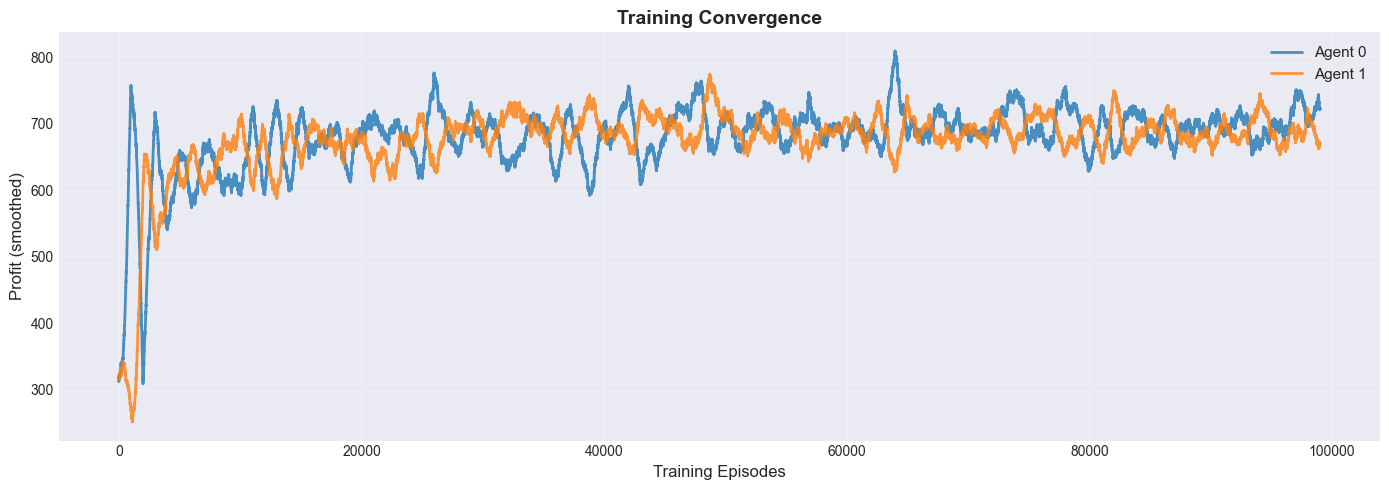

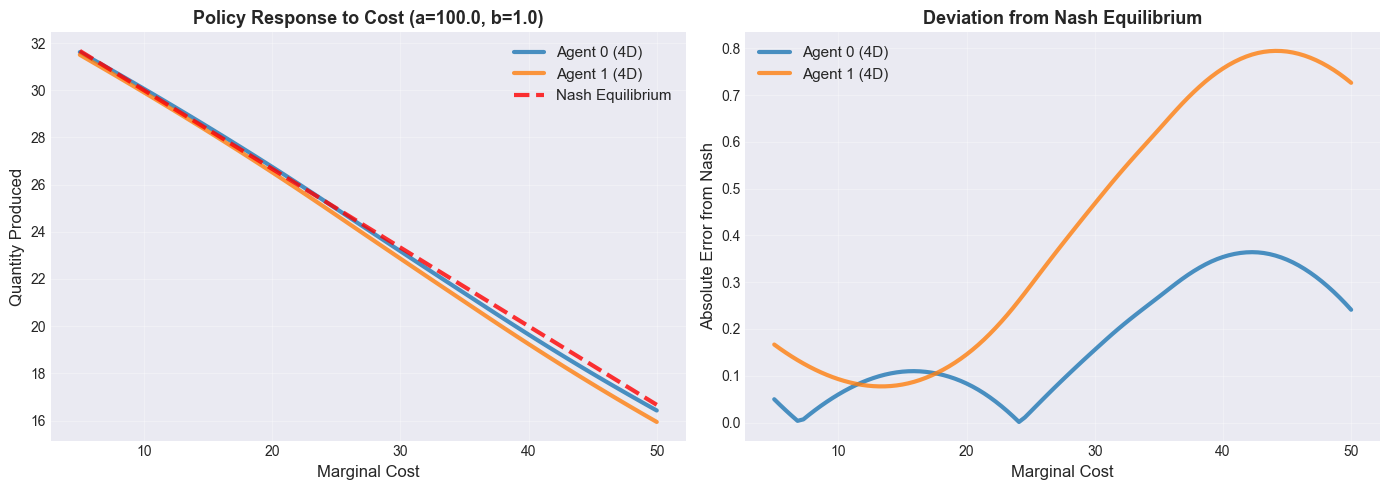

In [4]:
# Plot training convergence
fig = plot_training_convergence(history, window=1000, figsize=(14, 5))
plt.show()

# Plot how policies respond to different costs
fig = plot_policy_response(policies, env, a_fixed=100.0, b_fixed=1.0, figsize=(14, 5))
plt.show()

We can see that the agent follows closely the Nash equilibrium when it has perfect information.

## 2. Cournot Reinforcement Learning with Partial Information

Here we intend to use the same model, but we remove some knowledge to the agent to be get closer to real market conditions. That means that here, the agent uses the same process to learn but it doesn't know the the other firm's marginal cost but it still knows the demand's parameters

In [5]:
# Create environment (SAME as above)
env_config = {
    "a_min": 80.0,
    "a_max": 120.0,
    "b_min": 0.8,
    "b_max": 1.2,
    "cost_min": 5.0,
    "cost_max": 50.0,
    "q_max": 100.0,
    "seed": 42
}
env = CournotEnvironment(env_config)

# Create policies - learning agent + opponent (4D input - KEY DIFFERENCE!)
learning_agent = PolicyNetwork_asymmetrical(input_dim=3, hidden_dim=64)
opponent_agent = PolicyNetwork_asymmetrical(input_dim=3, hidden_dim=64)
policies = [learning_agent, opponent_agent]

# Training configuration (SAME as above)
config = {
    'episodes': 100000,  # ← Much longer!
    'lr_init': 0.005,    # ← Higher LR
    'lr_final': 0.0001,
    'warmup_steps': 15000,
    'sigma_init': 15.0,
    'sigma_final': 3.0,
    'sigma_decay': 0.99998,
    'print_interval': 10000
}

# Create trainer (SAME as above)
trainer = CournotTrainer(n_players=2, env=env, policies=policies, config=config)

# Train (SAME as above)
history = trainer.train(verbose=True)
partial_agent = learning_agent

Training 2 agents for 100000 episodes (simultaneous mode)
  Learning signal: regret minimization (normalized)
  Agent 0: PolicyNetwork_asymmetrical - Asymmetric (demand + cost)
  Agent 1: PolicyNetwork_asymmetrical - Asymmetric (demand + cost)
Episode 0/100000 | Avg Regret EMA: 0.0000
Episode 10000/100000 | Avg Regret EMA: 179.5227
Episode 20000/100000 | Avg Regret EMA: 140.3510
Episode 30000/100000 | Avg Regret EMA: 86.9948
Episode 40000/100000 | Avg Regret EMA: 73.2878
Episode 50000/100000 | Avg Regret EMA: 53.1907
Episode 60000/100000 | Avg Regret EMA: 37.1415
Episode 70000/100000 | Avg Regret EMA: 30.4638
Episode 80000/100000 | Avg Regret EMA: 23.2752
Episode 90000/100000 | Avg Regret EMA: 23.3262
Training complete!
  Final average regret (EMA): 21.1006
  Final average regret (cumulative/T): 92.1126


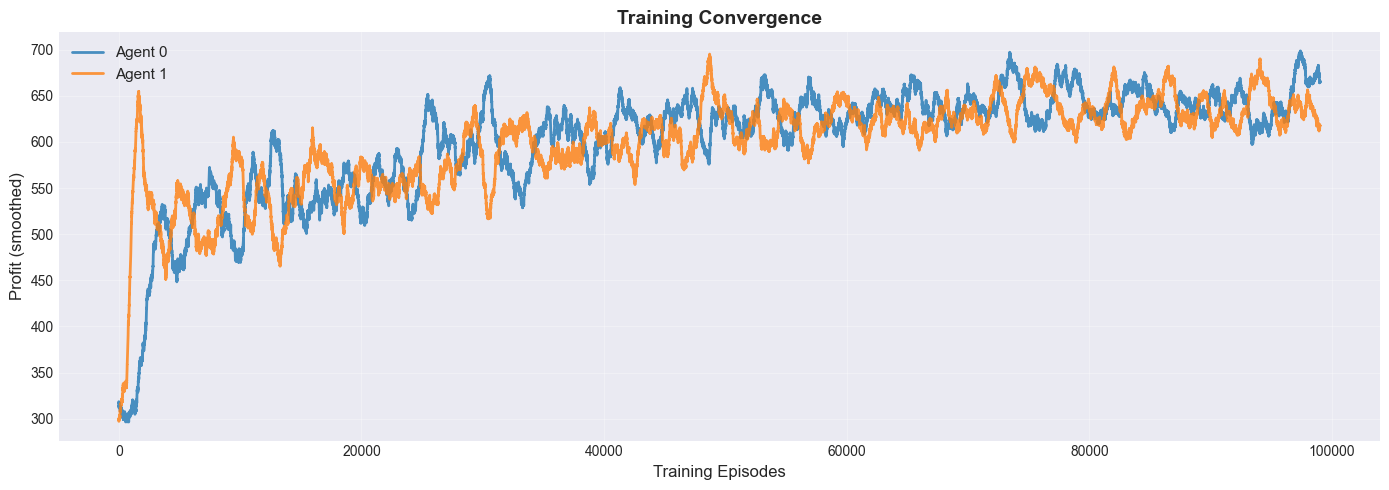

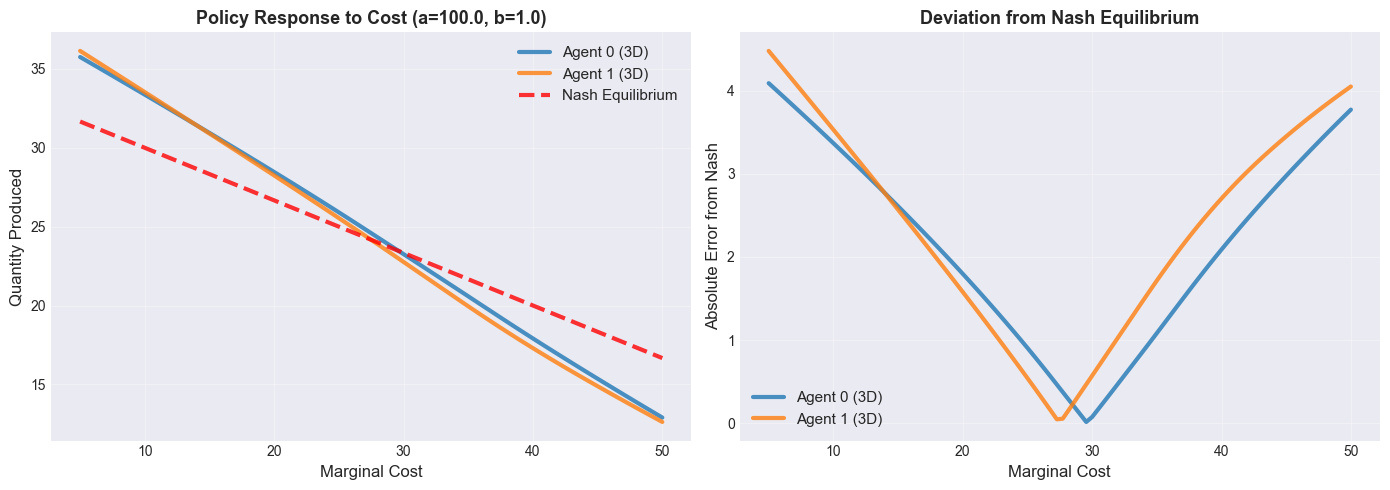

In [6]:
# Plot training convergence
fig = plot_training_convergence(history, window=1000, figsize=(14, 5))
plt.show()

# Plot how policies respond to different costs
fig = plot_policy_response(policies, env, a_fixed=100.0, b_fixed=1.0, figsize=(14, 5))
plt.show()

## 3. Cournot Reinforcement Learning with Asymmetric Information

Again, we remove some informations for our agent as here it doesn't know about demand's parameters and other firm's cost.

In [7]:
# Create environment (SAME as above)
env_config = {
    "a_min": 80.0,
    "a_max": 120.0,
    "b_min": 0.8,
    "b_max": 1.2,
    "cost_min": 5.0,
    "cost_max": 50.0,
    "q_max": 100.0,
    "seed": 42
}
env = CournotEnvironment(env_config)

# Create policies - learning agent + opponent (4D input - KEY DIFFERENCE!)
learning_agent = PolicyNetwork_asymmetrical(input_dim=1, hidden_dim=64)
opponent_agent = PolicyNetwork_asymmetrical(input_dim=1, hidden_dim=64)
policies = [learning_agent, opponent_agent]

# Training configuration (SAME as above)
config = {
    'episodes': 100000,  # ← Much longer!
    'lr_init': 0.005,    # ← Higher LR
    'lr_final': 0.0001,
    'warmup_steps': 15000,
    'sigma_init': 15.0,
    'sigma_final': 3.0,
    'sigma_decay': 0.99998,
    'print_interval': 10000
}

# Create trainer (SAME as above)
trainer = CournotTrainer(n_players=2, env=env, policies=policies, config=config)

# Train (SAME as above)
history = trainer.train(verbose=True)
asymmetric_agent  = learning_agent

Training 2 agents for 100000 episodes (simultaneous mode)
  Learning signal: regret minimization (normalized)
  Agent 0: PolicyNetwork_asymmetrical - Minimal (cost only)
  Agent 1: PolicyNetwork_asymmetrical - Minimal (cost only)
Episode 0/100000 | Avg Regret EMA: 0.0000
Episode 10000/100000 | Avg Regret EMA: 273.4700
Episode 20000/100000 | Avg Regret EMA: 153.0337
Episode 30000/100000 | Avg Regret EMA: 147.6488
Episode 40000/100000 | Avg Regret EMA: 119.2790
Episode 50000/100000 | Avg Regret EMA: 102.3913
Episode 60000/100000 | Avg Regret EMA: 94.6025
Episode 70000/100000 | Avg Regret EMA: 78.8347
Episode 80000/100000 | Avg Regret EMA: 68.9731
Episode 90000/100000 | Avg Regret EMA: 72.2861
Training complete!
  Final average regret (EMA): 71.1077
  Final average regret (cumulative/T): 130.4314


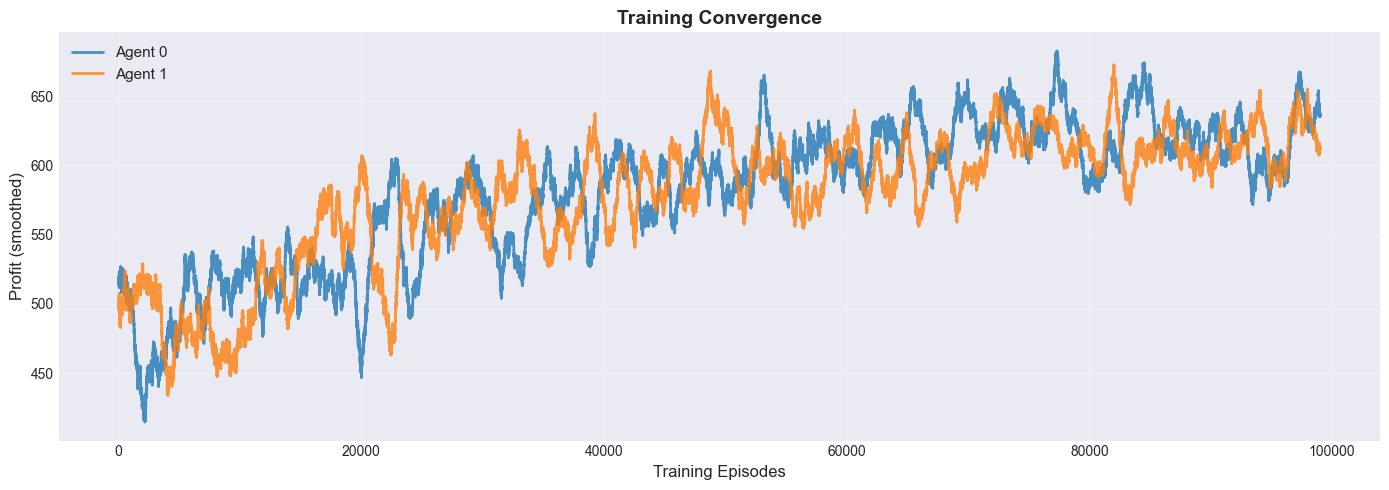

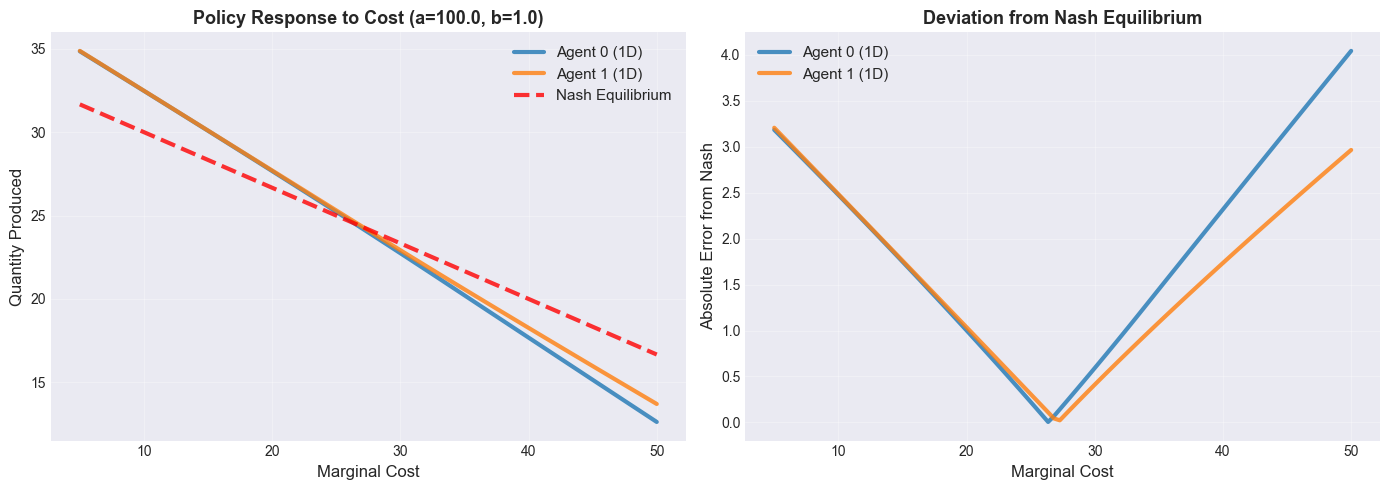

In [8]:
# Plot training convergence
fig = plot_training_convergence(history, window=1000, figsize=(14, 5))
plt.show()

# Plot how policies respond to different costs
fig = plot_policy_response(policies, env, a_fixed=100.0, b_fixed=1.0, figsize=(14, 5))
plt.show()

## 4. Save the trained agents

In [13]:
# First, fix the saving (re-run this cell if needed)
import pickle

# Save using pickle since these are custom numpy-based classes
with open("agent_perfect_info.pkl", "wb") as f:
    pickle.dump(nash_agent, f)
    
with open("agent_partial_info.pkl", "wb") as f:
    pickle.dump(partial_agent, f)
    
with open("agent_asymmetric_info.pkl", "wb") as f:
    pickle.dump(asymmetric_agent, f)

## 4. Testing
We are gonna extract the two agents: one that has learned with perfect information and one that has learned with asymmetric information. Then we will make them play against each other in a static cournot competition.
The first agent keep his perfect information meaning it will know the demand parameters and the other firm's marginal cost.

In [19]:
import pickle
import numpy as np

# Test environment configuration
test_env_config = {
    "a_min": 90.0,
    "a_max": 90.0,
    "b_min": 1.1,
    "b_max": 1.1,
    "cost_min": 10.0,
    "cost_max": 10.0,
    "q_max": 100.0,
    "seed": 123
}

test_env = CournotEnvironment(test_env_config)

# Load agents using pickle
with open("agent_perfect_info.pkl", "rb") as f:
    perfect_info_agent = pickle.load(f)
    
with open("agent_partial_info.pkl", "rb") as f:
    partial_info_agent = pickle.load(f)
    
with open("agent_asymmetric_info.pkl", "rb") as f:
    asymmetric_info_agent = pickle.load(f)

def evaluate_agents(env, policies, n_episodes=5000):
    """
    Evaluate agents with different information levels.
    Handles different input dimensions for each policy.
    """
    n_players = len(policies)
    profits = np.zeros((n_episodes, n_players))
    quantities = np.zeros((n_episodes, n_players))
    
    for ep in range(n_episodes):
        # Sample new market scenario
        a, b, costs = env.sample_scenario(n_players=n_players)
        
        actions = np.zeros(n_players)
        
        # Get action for each agent based on their input dimension
        for i, policy in enumerate(policies):
            # Construct state based on policy's input dimension
            if policy.input_dim == 1:
                # Only own cost
                state = np.array([costs[i]])
            elif policy.input_dim == 2:
                # Demand slope + own cost
                state = np.array([b, costs[i]])
            elif policy.input_dim == 3:
                # Full demand info + own cost (asymmetric)
                state = np.array([a, b, costs[i]])
            elif policy.input_dim == 4:
                # Perfect information (Nash)
                state = np.array([a, b, costs[i], costs[1-i]])
            else:
                raise ValueError(f"Unsupported input_dim: {policy.input_dim}")
            
            actions[i] = policy.forward(state)
        
        # Clip actions to valid range
        actions = np.clip(actions, 0.0, env.config["q_max"])
        
        # Calculate profits
        rewards = env.profit(actions, costs, a, b)
        
        profits[ep] = rewards
        quantities[ep] = actions
    
    return profits, quantities

# Calculate theoretical Nash equilibrium for comparison
a, b = 90.0, 1.1
c1, c2 = 10.0, 10.0  # Fixed costs in test environment
nash_q = test_env.nash_equilibrium(a, b, np.array([c1, c2]))
nash_price = test_env.price(nash_q, a, b)
nash_profit = (nash_price - c1) * nash_q[0]

print("\n" + "=" * 60)
print("THEORETICAL NASH EQUILIBRIUM (for reference)")
print("=" * 60)
print(f"Nash quantity per firm: {nash_q[0]:.2f}")
print(f"Nash market price: {nash_price:.2f}")
print(f"Nash profit per firm: {nash_profit:.2f}")


THEORETICAL NASH EQUILIBRIUM (for reference)
Nash quantity per firm: 24.24
Nash market price: 36.67
Nash profit per firm: 646.46


In [16]:
# Test 1: Perfect info vs Perfect info (baseline)
print("=" * 60)
print("TEST 1: Perfect Info vs Perfect Info")
print("=" * 60)
test_policies_1 = [perfect_info_agent, perfect_info_agent]
profits_1, quantities_1 = evaluate_agents(test_env, test_policies_1)

print(f"\nAgent 1 (Perfect Info):")
print(f"  Average profit: {profits_1[:, 0].mean():.2f} ± {profits_1[:, 0].std():.2f}")
print(f"  Average quantity: {quantities_1[:, 0].mean():.2f} ± {quantities_1[:, 0].std():.2f}")

print(f"\nAgent 2 (Perfect Info):")
print(f"  Average profit: {profits_1[:, 1].mean():.2f} ± {profits_1[:, 1].std():.2f}")
print(f"  Average quantity: {quantities_1[:, 1].mean():.2f} ± {quantities_1[:, 1].std():.2f}")

TEST 1: Perfect Info vs Perfect Info

Agent 1 (Perfect Info):
  Average profit: 650.75 ± 0.00
  Average quantity: 24.08 ± 0.00

Agent 2 (Perfect Info):
  Average profit: 650.75 ± 0.00
  Average quantity: 24.08 ± 0.00


In [17]:
# Test 2: Perfect info vs Partial info
print("\n" + "=" * 60)
print("TEST 2: Perfect Info vs Partial Info")
print("=" * 60)
test_policies_2 = [perfect_info_agent, partial_info_agent]
profits_2, quantities_2 = evaluate_agents(test_env, test_policies_2)

print(f"\nAgent 1 (Perfect Info):")
print(f"  Average profit: {profits_2[:, 0].mean():.2f} ± {profits_2[:, 0].std():.2f}")
print(f"  Average quantity: {quantities_2[:, 0].mean():.2f} ± {quantities_2[:, 0].std():.2f}")

print(f"\nAgent 2 (Partial Info - 3D):")
print(f"  Average profit: {profits_2[:, 1].mean():.2f} ± {profits_2[:, 1].std():.2f}")
print(f"  Average quantity: {quantities_2[:, 1].mean():.2f} ± {quantities_2[:, 1].std():.2f}")

print(f"\nProfit difference: {(profits_2[:, 0].mean() - profits_2[:, 1].mean()):.2f}")


TEST 2: Perfect Info vs Partial Info

Agent 1 (Perfect Info):
  Average profit: 557.26 ± 0.00
  Average quantity: 24.08 ± 0.00

Agent 2 (Partial Info - 3D):
  Average profit: 638.94 ± 0.00
  Average quantity: 27.61 ± 0.00

Profit difference: -81.69


In [18]:
# Test 3: Perfect info vs Asymmetric info (minimal)
print("\n" + "=" * 60)
print("TEST 3: Perfect Info vs Asymmetric Info (1D)")
print("=" * 60)
test_policies_3 = [perfect_info_agent, asymmetric_info_agent]
profits_3, quantities_3 = evaluate_agents(test_env, test_policies_3)

print(f"\nAgent 1 (Perfect Info):")
print(f"  Average profit: {profits_3[:, 0].mean():.2f} ± {profits_3[:, 0].std():.2f}")
print(f"  Average quantity: {quantities_3[:, 0].mean():.2f} ± {quantities_3[:, 0].std():.2f}")

print(f"\nAgent 2 (Asymmetric Info - 1D):")
print(f"  Average profit: {profits_3[:, 1].mean():.2f} ± {profits_3[:, 1].std():.2f}")
print(f"  Average quantity: {quantities_3[:, 1].mean():.2f} ± {quantities_3[:, 1].std():.2f}")

print(f"\nProfit difference: {(profits_3[:, 0].mean() - profits_3[:, 1].mean()):.2f}")


TEST 3: Perfect Info vs Asymmetric Info (1D)

Agent 1 (Perfect Info):
  Average profit: 428.35 ± 0.00
  Average quantity: 24.08 ± 0.00

Agent 2 (Asymmetric Info - 1D):
  Average profit: 577.72 ± 0.00
  Average quantity: 32.48 ± 0.00

Profit difference: -149.36


In [21]:
# Test 3: Partial info vs Partial info
print("\n" + "=" * 60)
print("TEST 3: Partial Info vs Partial Info")
print("=" * 60)
test_policies_3 = [partial_info_agent, partial_info_agent]
profits_3, quantities_3 = evaluate_agents(test_env, test_policies_3)

print(f"\nAgent 1 (Partial Info):")
print(f"  Average profit: {profits_3[:, 0].mean():.2f} ± {profits_3[:, 0].std():.2f}")
print(f"  Average quantity: {quantities_3[:, 0].mean():.2f} ± {quantities_3[:, 0].std():.2f}")

print(f"\nAgent 2 (Partial Info - 1D):")
print(f"  Average profit: {profits_3[:, 1].mean():.2f} ± {profits_3[:, 1].std():.2f}")
print(f"  Average quantity: {quantities_3[:, 1].mean():.2f} ± {quantities_3[:, 1].std():.2f}")

print(f"\nProfit difference: {(profits_3[:, 0].mean() - profits_3[:, 1].mean()):.2f}")


TEST 3: Partial Info vs Partial Info

Agent 1 (Partial Info):
  Average profit: 531.74 ± 0.00
  Average quantity: 27.61 ± 0.00

Agent 2 (Partial Info - 1D):
  Average profit: 531.74 ± 0.00
  Average quantity: 27.61 ± 0.00

Profit difference: 0.00


In [22]:
# Test 3: Partial info vs Partial info
print("\n" + "=" * 60)
print("TEST 3: Partial Info vs Asymmetric info")
print("=" * 60)
test_policies_3 = [partial_info_agent, asymmetric_info_agent]
profits_3, quantities_3 = evaluate_agents(test_env, test_policies_3)

print(f"\nAgent 1 (Partial Info):")
print(f"  Average profit: {profits_3[:, 0].mean():.2f} ± {profits_3[:, 0].std():.2f}")
print(f"  Average quantity: {quantities_3[:, 0].mean():.2f} ± {quantities_3[:, 0].std():.2f}")

print(f"\nAgent 2 (Asymmetric info):")
print(f"  Average profit: {profits_3[:, 1].mean():.2f} ± {profits_3[:, 1].std():.2f}")
print(f"  Average quantity: {quantities_3[:, 1].mean():.2f} ± {quantities_3[:, 1].std():.2f}")

print(f"\nProfit difference: {(profits_3[:, 0].mean() - profits_3[:, 1].mean()):.2f}")


TEST 3: Partial Info vs Asymmetric info

Agent 1 (Partial Info):
  Average profit: 383.94 ± 0.00
  Average quantity: 27.61 ± 0.00

Agent 2 (Asymmetric info):
  Average profit: 451.62 ± 0.00
  Average quantity: 32.48 ± 0.00

Profit difference: -67.68


In [23]:
# Test 3: Asymmetric info vs Asymmetric info
print("\n" + "=" * 60)
print("TEST 3: Partial Info vs Asymmetric info")
print("=" * 60)
test_policies_3 = [asymmetric_info_agent, asymmetric_info_agent]
profits_3, quantities_3 = evaluate_agents(test_env, test_policies_3)

print(f"\nAgent 1 (Asymmetric Info):")
print(f"  Average profit: {profits_3[:, 0].mean():.2f} ± {profits_3[:, 0].std():.2f}")
print(f"  Average quantity: {quantities_3[:, 0].mean():.2f} ± {quantities_3[:, 0].std():.2f}")

print(f"\nAgent 2 (Asymmetric info):")
print(f"  Average profit: {profits_3[:, 1].mean():.2f} ± {profits_3[:, 1].std():.2f}")
print(f"  Average quantity: {quantities_3[:, 1].mean():.2f} ± {quantities_3[:, 1].std():.2f}")

print(f"\nProfit difference: {(profits_3[:, 0].mean() - profits_3[:, 1].mean()):.2f}")


TEST 3: Partial Info vs Asymmetric info

Agent 1 (Asymmetric Info):
  Average profit: 277.77 ± 0.00
  Average quantity: 32.48 ± 0.00

Agent 2 (Asymmetric info):
  Average profit: 277.77 ± 0.00
  Average quantity: 32.48 ± 0.00

Profit difference: 0.00
